In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

words[:10]

# 32k example
len(words)

# min length 2
min(len(w) for w in words)

# max length 15
max(len(w) for w in words)

# we want to think about the bigrams - what is the frequency of any given letter being followed by another letter

# break down word to bigrams
b = {} # keep track of counts
for w in words:
    # special characters for 'start' / 'end'
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

counts = sorted(b.items(), key=lambda kv: -kv[1])
 

In [3]:
# bigram count matrix
N = torch.zeros((27, 27), dtype=torch.int32)

# list of chars a-z
chars = sorted(list(set(''.join(words))))

# lookup table char -> index in a-z (including '.' delimiter character for first)
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

# we want a index -> char table as well
itos = {i: s for s,i in stoi.items()}

for w in words:
    # special characters for 'start' / 'end'
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        bigram = (ch1, ch2)
        N[ix1, ix2] += 1

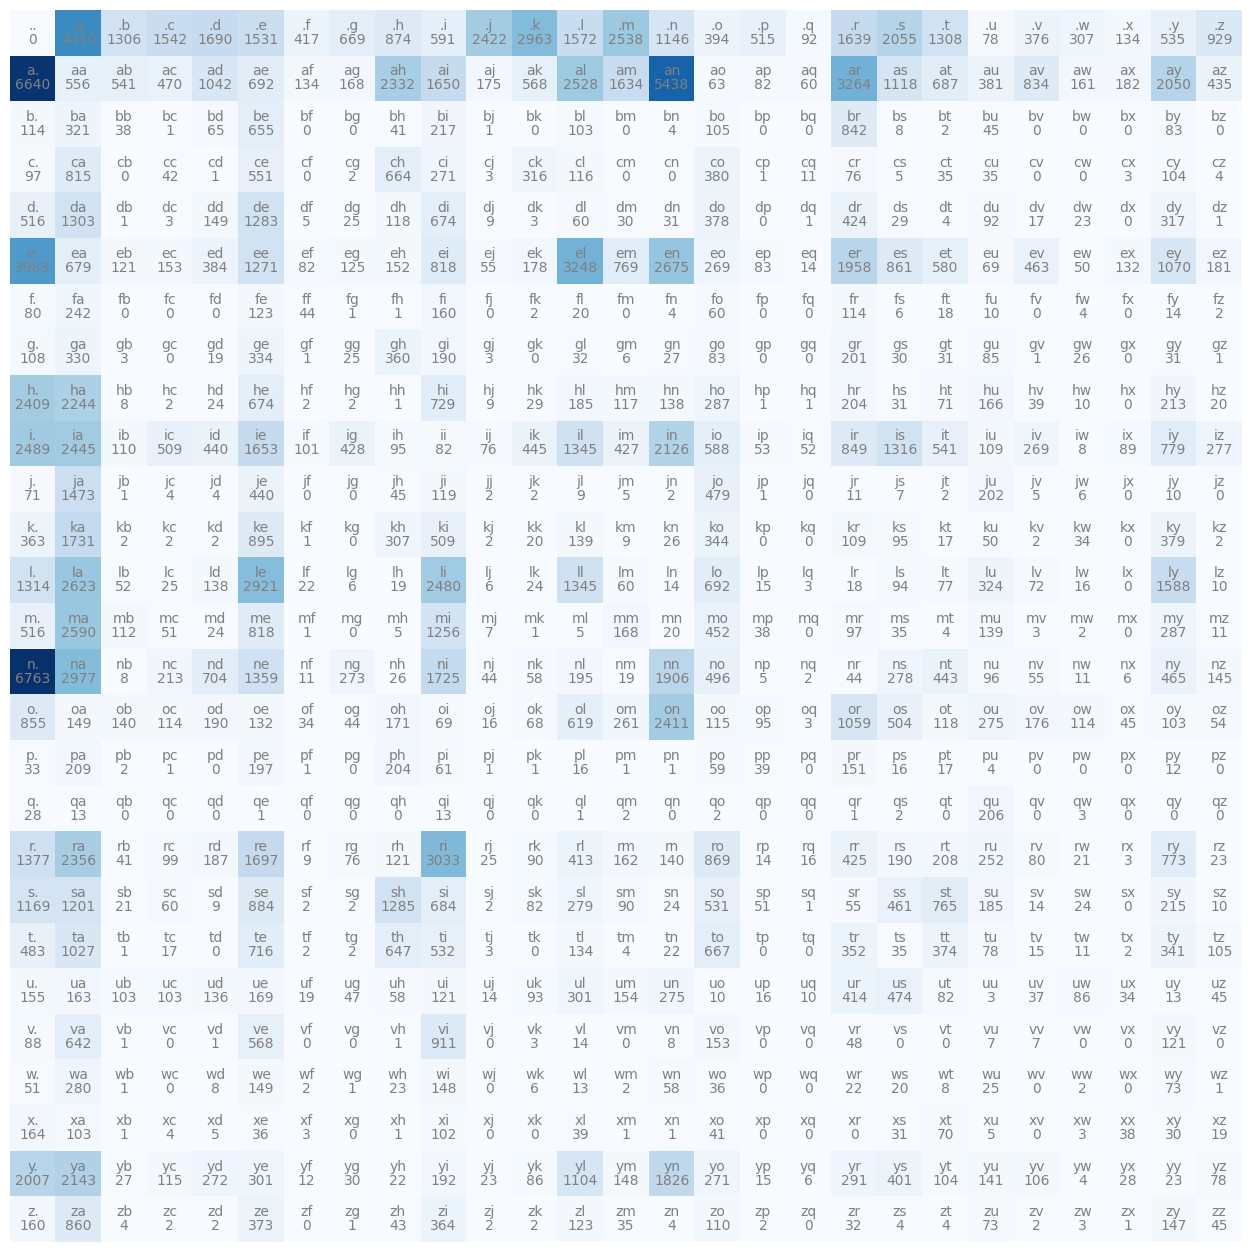

In [4]:
# visualizer - we have counts for our entire data set that captures all the bigrams, including metacharacters like 'start token' and 'end token' 

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

Even the most basic analysis can tell us things like:

- The most frequent start letter is 'a'
- the most frequent end letters are 'a' and 'n'
- 'an' is our most frequent bigram
- some of our data points are pointless - a word will never start with the `<E>` token for example, nor end with `<S>` - room to optimize!

N

In [5]:
# N is our 27 x 27 nigram tensor
N
# our first row represents the counts for [aa, ab, ac, ad ... a.]
N[0]

# cast our sample into floats (was int32) and normalize by total counts
p = N[0].float()
p = p / p.sum()
# p now represents the frequencies of a followed by another character, as compared against all characters, summing in total to 1
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [6]:
# for what we want to do next we need predictable random #s
g = torch.Generator().manual_seed(2147483647) # manual seed is just to make this 'trackable' and not change on each run
p = torch.rand(3, generator=g)
# p holds 3 random #s now between 0 and 1
p = p / p.sum()
# p now equals 3 random normalized values (sum to 1) 
print(p)
# now we can use this random distro split in 3 to produce data matching that distro using torch.multinomial
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
# by setting the sample size to 1 we can now get a single value from [0, 1, 2] with the generated distribution
ix.item()

tensor([0.6064, 0.3033, 0.0903])


0

tensor([[32033.],
        [33885.],
        [ 2645.],
        [ 3532.],
        [ 5496.],
        [20423.],
        [  905.],
        [ 1927.],
        [ 7616.],
        [17701.],
        [ 2900.],
        [ 5040.],
        [13958.],
        [ 6642.],
        [18327.],
        [ 7934.],
        [ 1026.],
        [  272.],
        [12700.],
        [ 8106.],
        [ 5570.],
        [ 3135.],
        [ 2573.],
        [  929.],
        [  697.],
        [ 9776.],
        [ 2398.]])


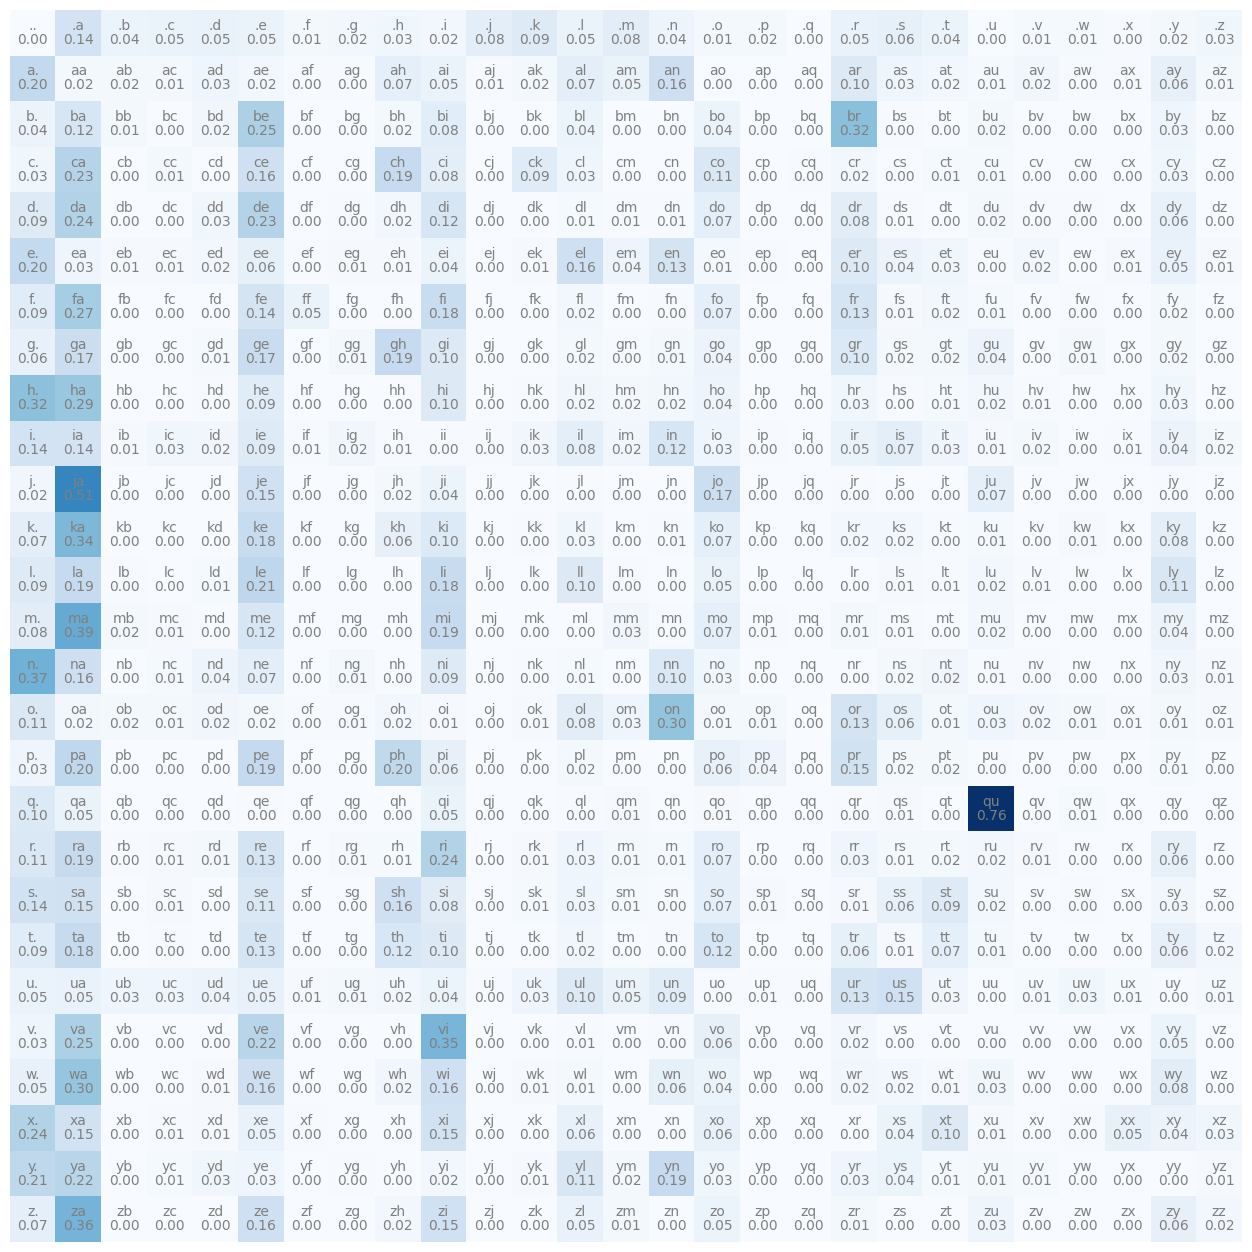

In [7]:
# optimization - turn out predictions into a tensor instead of doing it by hand each time
P = N.float()

# understanding sum/keepdim
# S = P.sum() # will sum the entire 27 x 27 matrix and return a scalar
# S = P.sum(0) # will sum the matrix by col and return a 27 elem array
# S = P.sum(1) # will sum the matrix by row and return a 27 elem array
# S = P.sum(0, keepdim=True) # will sum the matrix by col and return a 1 x 27 matrix
S = P.sum(1, keepdim=True) # will sum the matrix by row and return a 27 x 1 matrix

# ultimately this is what we want for matrix multipliction because it is transposed
# our final matrix S has 27 cols, each with a single row holding the sum of the equivalent row at P
print(S)

P = P / S

# frequency per letter map
plt.figure(figsize=(16,16))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, "{:.2f}".format(P[i, j].item()), ha="center", va="top", color='gray')
plt.axis('off');

In [8]:
# now let's apply this to our bigram problem
# start at 0 (. = <S>)
names = []

for i in range(30):
  ix = 0
  name = []

  while True:
    # given that frequency distribution, get a random index
    ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
    name.append(itos[ix])
    # stop when the next random letter chosen is an end char symbol (. = <E>)
    if ix == 0:
      names.append(''.join(name))
      break

# wow, these are some pretty bad names
names

['ylia.',
 'toe.',
 'amejm.',
 'tte.',
 'arullaha.',
 'al.',
 'aya.',
 'ti.',
 'ebr.',
 'hai.',
 'sthia.',
 'adde.',
 'eiigi.',
 'depry.',
 'wileynal.',
 'lusavyviymyariprishan.',
 'y.',
 'zzan.',
 'jamiy.',
 'a.',
 'ah.',
 'qumaynah.',
 'k.',
 'shan.',
 'el.',
 'ly.',
 'don.',
 'rdi.',
 'a.',
 'suk.']